In [113]:
#Import necessary libraries
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from statistics import mean 
from statistics import variance
from scipy import optimize
import matplotlib.pyplot as plt
import scipy.special
import pandas as pd
from prettytable import PrettyTable



#project parameters:

T=1
m=4
dt=1.0/4.0
A="P"
r=0.025
K=140
k=7
s=0.49
S0=130
sigma=0.39
V0 = 1.7
kappa = 2
theta=0.045
rho=-0.5711
c=0.216
N=20000
P=[]
S=[]
G=[]      
epsilon=0
  
   
    
#Black-Scholes Model:    
    
def BS(S0, r, m, sigma, T):    
    d=float(T)/float(m)
    SSInf=[S0]
    SSup=[S0]  
    gaussians = np.random.normal(0, 1, m)

    for i in range(m):
        SSInf.append(SSInf[-1]*math.exp((r-(1/2)*(sigma**2))*d + sigma*math.sqrt(d)*gaussians[i]))
        SSup.append(SSup[-1]*math.exp((r-(1/2)*(sigma**2))*d - sigma*math.sqrt(d)*gaussians[i]))
    
    return (SSInf,SSup)

#Heston Model:

def H(S0,V0, r, m, sigma,kappa,theta, T):
	dt= 1/100.0
	V=[V0]
	V1=[V0]
	S=[S0] 
	S1=[S0]
	for i in range(m-1):
		x=np.random.normal(0, 1, 1)      
		y=rho*np.random.normal(0, 1, 1)+math.sqrt(1.0-rho*rho)*x
		S.append(float((S[-1]*(1+r*dt+math.sqrt(dt*V[-1])*x ))))
		V.append(float((V[-1]+kappa*(theta-V[-1])*dt+sigma*math.sqrt(dt*V[-1])*y)))
		S1.append(float((S[-1]*(1+r*dt+math.sqrt(dt*V[-1])*(-x) ))))
		V1.append(float((V[-1]+kappa*(theta-V[-1])*dt+sigma*math.sqrt(dt*V[-1])*(-y))))
	return (S,S1) 





In [114]:
plt.style.use('ggplot')
mydata = pd.read_csv('AAPL.csv')
mydata.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,74.207466,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,73.486023,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,74.071579,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,73.723213,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,74.909149,132079200


<AxesSubplot:>

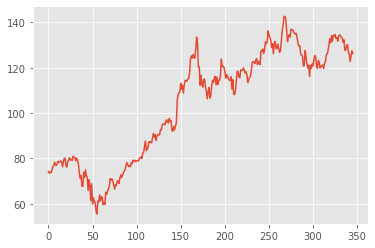

In [111]:
mydata['Adj Close'].plot()

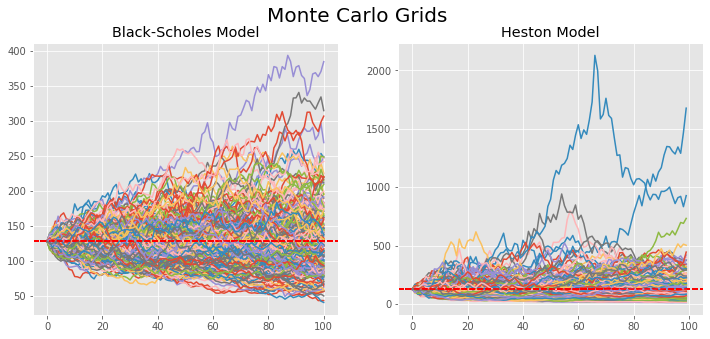

In [212]:
data= mydata['Adj Close'].tolist()
train_data=data[:-100]
last_price=train_data[-1]


fig, (ax1, ax2) =  plt.subplots(1, 2, sharex=True)
fig.suptitle('Monte Carlo Grids', size=20)
fig.set_size_inches(12, 5)

for i in range (100):
    ax1.plot(BS(train_data[-1], r, 100, sigma, T)[0])
    ax1.plot(BS(train_data[-1], r, 100, sigma, T)[1])
    ax1.axhline(y = last_price, color = 'r', linestyle = '--')
    ax1.title.set_text('Black-Scholes Model')
    ax2.plot(H(train_data[-1],V0, r, 100, sigma,kappa,theta, T)[0])
    ax2.plot(H(train_data[-1],V0, r, 100, sigma,kappa,theta, T)[1])
    ax2.axhline(y = last_price, color = 'r', linestyle = '--')
    ax2.title.set_text('Heston Model')
    
plt.show()

In [ ]:
#Heston model when we only use 4 observations
def H(S0,V0, r, m, sigma,kappa,theta, T):
	dt= 1/100.0
	V=[V0]
	V1=[V0]
	S=[S0] 
	S1=[S0]
	for i in range(m-1):
		x=np.random.normal(0, 1, 1)      
		y=rho*np.random.normal(0, 1, 1)+math.sqrt(1.0-rho*rho)*x
		S.append(float((S[-1]*(1+r*dt+math.sqrt(dt*V[-1])*x ))))
		V.append(float((V[-1]+kappa*(theta-V[-1])*dt+sigma*math.sqrt(dt*V[-1])*y)))
		S1.append(float((S[-1]*(1+r*dt+math.sqrt(dt*V[-1])*(-x) ))))
		V1.append(float((V[-1]+kappa*(theta-V[-1])*dt+sigma*math.sqrt(dt*V[-1])*(-y))))
	return([S[24],S[49] ,S[74] ,S[99] ],[S1[24],S1[49] ,S1[74] ,S1[99] ])



#Weighted laguerre Polynomials

def laguerre(xx,nn):
    L=[]
    xx=xx/K
    for l in range (nn):
        L.append(math.exp(-xx/2)*scipy.special.eval_laguerre(l, xx, out=None))
    return(L)


def laguerre2(x,t):
    L=[1]
    t=t*dt
    
    L.append(math.exp(-x/(K*2)))
    L.append( math.exp(-x/(K*2))*(1 - x/(K*2))  )
    L.append( math.exp(-x/(K*2))*(1 - 2*x/K +((x/K)**2)/2 ))
    L.append(math.sin((math.pi*(-t))/(2*T)+ math.pi/2 ))
    L.append(math.log(T-t))
    L.append(((t/T)**2))
    return(np.matrix(L))




#Least squares Monte Carlo (LSM)

def LSM(S,P, K, A, r, T ,m, k, N, PVV ):
    
    Ex=0
    Cont=0
    BB=[0 for _ in range(m)]
    XX=[]
    YY=[]
    for j in range(m-2,0,-1):
        X=[]
        Y=[]
        for i in range (N):
            #P[i]*=math.exp(-r*dt)
            Y.append(PVV[i][-1])
            X.append(laguerre(S[i][j],k))
        try :
            YY=np.array(Y)  
            XX=np.array(X)  
            BB[j]=np.dot(np.dot(np.linalg.inv(np.dot(np.matrix.transpose(XX),XX)) ,np.matrix.transpose(XX)),YY)
        except :
            BB[j]=0.0
            continue
    pp=[]
    
    
    for i in range(N):
        value=0.0
        exerciced = False
        for j in range(m-1):
            if not exerciced :
                try:
                    conValue=np.dot(np.matrix.transpose(BB[j]),laguerre(S[i][j],k))*math.exp(-r*dt)
                except:
                    conValue=0.0
                if PVV[i][j]>conValue :
                    value=PVV[i][j+1]*math.exp(-r*dt*j)
                    exerciced=True
            if j==m-1 and not exerciced:
                value=PVV[i][-1]*math.exp(-r*dt*j)
        pp.append(value)
 
    return(pp)




#Fitted Q-iteration 

def FQI(S, K, r, T ,m,k, N, PVV, train,w):
    F=[]
    D=[]
    R=[]
    Y=[0.0 for i in range (N)]
    A=np.matrix([[0.0 for i in range (k)]for jj in range (k)])
    B=np.matrix([0.0 for i in range (k)])
    P=np.matrix([0 for i in range(k)])
    
    if train ==True:
        w=np.matrix([0.0 for i in range (k)])
        
        x1=100

        for i in range (N):

            for j in range(0, m-1):

                Q=PVV[i][j+1]


                if (j<m-2) :
                    P= laguerre2(S[i][j+1],j+1)

                else:
                    P=np.matrix([0 for i in range(k)])


                A += (laguerre2(S[i][j],j).transpose())*laguerre2(S[i][j],j) 
                B += math.exp(-r*dt)*( max(PVV[i][j+1],float(P*(w.transpose())))) * laguerre2(S[i][j],j)
                
            if (i+1)%10==0:
                w=B*np.linalg. inv(A)
                A=np.matrix([[0.0 for i in range (k)]for i in range (k)])
                B=np.matrix([0.0 for i in range (k)])

       
    for i in range (N):
        exerciced = False
        for j in range(m) :
            Q=PVV[i][j]
            if not exerciced :
                x=max(0.0,float(laguerre2(S[i][j],j)*(w.transpose())))
                if Q >=x*math.exp(-r*dt):
                    Y[i]=Q*math.exp(-r*j*dt)
                    exerciced= True
                    break
            if j==m-1 and not exerciced:
                    Y[i]=Q*math.exp(-r*j*dt)
    return(mean(Y),w)   




#Least-Squares Policy Iteration

def LSPI(S, K, r, T ,m,k, N,PVV, train,w ):
    F=[]
    D=[]
    R=[]
    Y=[0.0 for i in range (N)]
    A=np.matrix([[0.0 for i in range (k)]for jj in range (k)])
    B=np.matrix([0.0 for i in range (k)])
    
    P=np.matrix([0 for i in range(k)])  
    x1=100
    
    if train == True:
        w=np.matrix([0.0 for i in range (k)])
        for i in range (N):

            for j in range(0, m-1):

                Q=PVV[i][j+1]

                x=float(laguerre2(S[i][j+1],j+1)*(w.transpose()))
                if (Q <= x and j<m-2) :
                    P= laguerre2(S[i][j+1],j+1)

                else:
                    P=np.matrix([0 for i in range(k)])

                x2=float(P*(w.transpose()))

                if Q > x2:
                    R=Q 
                else:
                    R=0.0

                A += (laguerre2(S[i][j],j).transpose())* ((laguerre2(S[i][j],j)-(math.exp(-r*dt)*P)))
                B += math.exp(-r*dt)* R * laguerre2(S[i][j],j)
                
            if (i+1)%10==0:
                w=B*np.linalg. inv(A)
                A=np.matrix([[0.0 for i in range (k)]for i in range (k)])
                B=np.matrix([0.0 for i in range (k)])
    
       
    for i in range (N):
        exerciced = False
        for j in range(m) :
            Q=PVV[i][j]
            if not exerciced :
                x=max(0.0,float(laguerre2(S[i][j],j)*(w.transpose())))
                if Q >=x*math.exp(-r*dt):
                    Y[i]=Q*math.exp(-r*j*dt)
                    exerciced= True
                    break
            if j==m-1 and not exerciced:
                    Y[i]=Q*math.exp(-r*j*dt)
    return(mean(Y),w) 






#Aut-call payOff function

def PayOff(SS,j, x, c):
    SS=SS
    global Ko  
    if j==0:
        if (SS<1.2*140/(1+x)):
            return(-c)
        else:
            Ko=True
            return(SS/140.0*(1+x))
    elif j==1:
        if (SS<1.2*140/(1+x)):
            return(-c)
        else:
            Ko=True
            return(SS/140.0*(1+x))
    elif j==2:
        if (SS<1.2*140/(1+x)):
            return(-c)
        else:
            Ko=True
            return(SS/140.0*(1+x))
        
    elif j==3:
        return(SS/140.0*(1+x))


#Option expected value function   

def FOp(c):
    
    P=[]
    global PV
    for i in range (N):      
        Ko=False
        for j in range(4):
            if Ko==True:
                break
            PV[i][j]=PayOff(S[i][j],j, epsilon,c)

    for i in range (N):      
        for j in range(1,4):
            PV[i][j]+=PV[i][j-1]
        P.append(PV[i][-1])
    return(mean(P))




def f( S, t, train, w2,w3 ):
    global c 
    global PV
    if t==True:
        #calculate the value of c
        c= optimize.newton(FOp, 0.5, tol=1e-03, maxiter=200)
    for i in range (N):      
        Ko=False
        for j in range(4):
            if Ko==True:
                break
            PV[i][j]=PayOff(S[i][j],j, epsilon,c)

    Ait=LSM(S,P, K, A, r, T ,m,k, N, PV )
    a1=mean(Ait)
    b1=LSPI(S, K, r, T ,m,k, N, PV,train,w2 )
    c1=FQI(S, K, r, T ,m,k, N, PV, train, w3 )

    return a1,b1,c1



In [26]:
w2=0
w3=0
    
    
for x3 in (train_data):
    
    S=[]
    PV=[[0.0 for r1 in range(4)] for r2 in range (N)]
    S0=x3
    count=0

    while count<(N//2):
        try:
            a,b=H(S0,V0, r, 100, sigma,kappa,theta, T)
            S.append( a)
            S.append( b)
            count+=1
        except:
            continue 
    
    epsilon=0  
    a=np.array(f( S, True, True, w2, w3))
    w2, w3 =a[1][2],a[2][2]
    
    print('Day number ' +str(data1.index(x3))+' is completed')

<ipython-input-26-4996835ad168>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a=np.array(f( S, True, True, w2, w3))


Day number 0 is completed
Day number 1 is completed
Day number 2 is completed
Day number 3 is completed
Day number 4 is completed
Day number 5 is completed
Day number 6 is completed
Day number 7 is completed
Day number 8 is completed
Day number 9 is completed
Day number 10 is completed
Day number 11 is completed
Day number 12 is completed
Day number 13 is completed
Day number 14 is completed
Day number 15 is completed
Day number 16 is completed
Day number 17 is completed
Day number 18 is completed
Day number 19 is completed
Day number 20 is completed
Day number 21 is completed
Day number 22 is completed
Day number 23 is completed
Day number 24 is completed
Day number 25 is completed
Day number 26 is completed
Day number 27 is completed
Day number 28 is completed
Day number 29 is completed
Day number 30 is completed
Day number 31 is completed
Day number 32 is completed
Day number 33 is completed
Day number 34 is completed
Day number 35 is completed
Day number 36 is completed
Day number 

In [45]:
test_data=data[-50:]

data={'PriceLSM':[], 'PriceLSPI':[], 'PriceFQI':[], 'DeltaLSM':[], 'DeltaLSPI':[], 'DeltaFQI':[] }

    
    
for x3 in (test_data):
    
    S=[]
    PV=[[0.0 for r1 in range(4)] for r2 in range (N)]
    S0=x3
    count=0

    while count<(N//2):
        try:
            a,b=H(S0,V0, r, 100, sigma,kappa,theta, T)
            S.append( a)
            S.append( b)
            count+=1
        except:
            continue     
    epsilon=0  
    a=np.array(f( S, True, False, w2, w3))
    PriceLSM,PriceLSPI, PriceFQI =a[0], a[1][0],a[2][0]
    data['PriceLSM'].append(PriceLSM)
    data['PriceLSPI'].append(PriceLSPI)
    data['PriceFQI'].append(PriceFQI)
    epsilon=0.1
    b=np.array(f( S, False, False, w2, w3))
    DeltaLSM, DeltaLSPI, DeltaFQI =(1/(epsilon*S0))*(b[0]-a[0]),(1/(epsilon*S0))*(b[1][0]-a[1][0]),(1/(epsilon*S0))*(b[2][0]-a[2][0])
    data['DeltaLSM'].append(DeltaLSM)
    data['DeltaLSPI'].append(DeltaLSPI)
    data['DeltaFQI'].append(DeltaFQI)
    print('Day number ' +str(data1.index(x3))+' is completed')


<ipython-input-45-ad721c77d2f6>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a=np.array(f( S, True, False, w2, w3))
<ipython-input-45-ad721c77d2f6>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  b=np.array(f( S, False, False, w2, w3))


Day number 0 is completed
Day number 1 is completed
Day number 2 is completed
Day number 3 is completed
Day number 4 is completed
Day number 5 is completed
Day number 6 is completed
Day number 7 is completed
Day number 8 is completed
Day number 9 is completed
Day number 10 is completed
Day number 11 is completed
Day number 12 is completed
Day number 13 is completed
Day number 14 is completed
Day number 15 is completed
Day number 16 is completed
Day number 17 is completed
Day number 18 is completed
Day number 19 is completed
Day number 20 is completed
Day number 21 is completed
Day number 22 is completed
Day number 23 is completed
Day number 24 is completed
Day number 25 is completed
Day number 26 is completed
Day number 27 is completed
Day number 28 is completed
Day number 29 is completed
Day number 30 is completed
Day number 31 is completed
Day number 32 is completed
Day number 33 is completed
Day number 34 is completed
Day number 35 is completed
Day number 36 is completed
Day number 

In [130]:
# Saving the reults 
results=pd.DataFrame(data)
results['Price']=mydata['Adj Close'][-50:].values

## Back testing

#### Calculate daily Profit and Loss P&L

In [132]:
PnLLSM=[0]
PnLLSPI=[0]
PnLFQI=[0]

In [133]:
for i in range(50-1):
    
    PnLLSM.append((results.Price[i+1]-results.Price[i])*results.DeltaLSM[i]-(results.PriceLSM[i+1]-results.PriceLSM[i]))
    PnLLSPI.append((results.Price[i+1]-results.Price[i])*results.DeltaLSPI[i]-(results.PriceLSPI[i+1]-results.PriceLSPI[i]))
    PnLFQI.append((results.Price[i+1]-results.Price[i])*results.DeltaFQI[i]-(results.PriceFQI[i+1]-results.PriceFQI[i]))

In [182]:
results['PnLLSM']=PnLLSM
results['PnLLSPI']=PnLLSPI
results['PnLFQI']=PnLFQI
results=results.iloc[:, 1:]

In [183]:
results.head()

,PriceLSM,PriceLSPI,PriceFQI,DeltaLSM,DeltaLSPI,DeltaFQI,Price,PnLLSM,PnLLSPI,PnLFQI
0,0.303681,0.832800,0.833502,0.004854,0.007120,0.007114,116.162689,0.000000,0.000000,0.000000
1,0.310009,0.862177,0.863030,0.005561,0.007130,0.007087,120.884666,0.016592,0.004242,0.004066
2,0.319552,0.851228,0.852426,0.004492,0.007015,0.007015,119.776558,-0.015704,0.003048,0.002751
3,0.325034,0.867035,0.867513,0.004585,0.007142,0.007146,121.753189,0.003396,-0.001942,-0.001222
4,0.311635,0.862466,0.864547,0.004599,0.007161,0.007163,120.824768,0.009142,-0.002062,-0.003668


In [136]:
#Save the results to an Excel spreadsheet
results.to_excel("results.xlsx")

#### Price Analysis

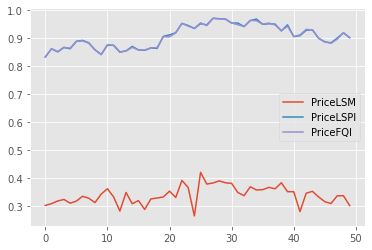

In [187]:
#Option price analysis
results.iloc[:,:3].plot() 
plt.show()

###### We notice that both LSPI and FQI produce a higher price than LSM, that's because Q-learning methods can discover better opportunities to exercise the option.

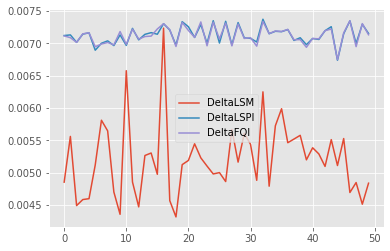

In [185]:
#Delta Analysis
results.iloc[:,3:6].plot() 
plt.show()

###### LSM method results in a fluctuated delta values in comparison to the other methods. Next we will look at the mean and standard deviation of delta values of each method:

In [191]:
results.iloc[:, -7:-4].describe()[1:3]

,DeltaLSM,DeltaLSPI,DeltaFQI
mean,0.005206,0.007127,0.007122
std,0.000563,0.000135,0.000134


In [201]:
results['DeltaLSM'].std()/results['DeltaLSPI'].std()

4.170765799860538

In [200]:
results['DeltaLSM'].std()/results['DeltaFQI'].std()

4.198343177990086

#### Profit and Loss Analysis

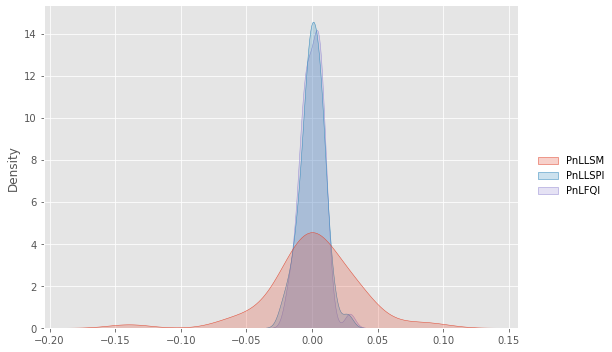

In [164]:
sns.displot(data=results.iloc[:,8:], kind="kde", fill=True,  aspect=1.5)

In [165]:
results.iloc[:, -3:].describe()

,PnLLSM,PnLLSPI,PnLFQI
count,50.000000,50.000000,50.000000
mean,0.000840,0.000122,0.000157
std,0.035137,0.009166,0.008654
min,-0.139697,-0.022766,-0.018651
25%,-0.012411,-0.005103,-0.005697
50%,0.001750,-0.000153,0.000672
75%,0.015758,0.006292,0.005913
max,0.092508,0.026883,0.028822


In [207]:
import seaborn as sns
results.iloc[:, -3:].describe().iloc[[3,-1]]

,PnLLSM,PnLLSPI,PnLFQI
min,-0.139697,-0.022766,-0.018651
max,0.092508,0.026883,0.028822


In [268]:
d1,d2,d3 = ['LSM'],['LSPI'],['FQI']
for i in [0.01,0.02,0.03]:

    d1.append(results['PnLLSM'][abs(results['PnLLSM'])<i].count()/len(results['PnLLSM'])*100)
    d2.append(results['PnLLSPI'][abs(results['PnLLSPI'])<i].count()/len(results['PnLLSPI'])*100)
    d3.append(results['PnLFQI'][abs(results['PnLFQI'])<i].count()/len(results['PnLFQI'])*100)

table = PrettyTable()
table.add_row(['[-0.1,0.1]', d1[1], d2[1], d3[1]])
table.add_row(['[-0.2,0.2]', d1[2], d2[2], d3[2]])
table.add_row(['[-0.3,0.3]', d1[3], d2[3], d3[3]])
table.field_names = ['Interval', 'LSM','LSPI','FQI']
table.title = 'Confidence intervals'
print(table)

+-----------------------------------+
|        Confidence intervals       |
+------------+------+-------+-------+
|  Interval  | LSM  |  LSPI |  FQI  |
+------------+------+-------+-------+
| [-0.1,0.1] | 36.0 |  80.0 |  82.0 |
| [-0.2,0.2] | 60.0 |  96.0 |  98.0 |
| [-0.3,0.3] | 72.0 | 100.0 | 100.0 |
+------------+------+-------+-------+


###### We see that LSPI and FQI have a density of P&L clustered around 0, with a standar deviation 4 times smaller than the usual LSM. Also, we see that, condfidence intervals for LSPI and FQI of daily P&L values are significently wider than those LSM . Thus, Q-learning methods can produce a better hedging.